# Imports

In [1]:
import sys
import os
from molgroups import components as cmp
from molgroups import mol
from molgroups import lipids
import numpy as np

from bumps.cli import load_model, load_best
import matplotlib.pyplot as plt
from molgroups.support import molstat

# Variables

Variables to set the storage folder for the fit, the base name of the runfile, and the global optimizer. Further the
number of burn and production stepst for the MCMC are set. The run flag determines whether the refl1d MCMC is run, or
just a data analysis on a previous fit is performed.

Steps (and burn) are intentionally small in this example to reduce file sizes.

In [2]:
setupdir = os.getcwd()
store = "fit"
runfile = "noblm"
fitsource = "refl1d"

if not os.path.isdir(store):
    os.mkdir(store)

run = True
burn = 100
steps = 100


# Example Fit

The content of the following cell is written out to the runfile of the fit 'tblm.py'.

In [3]:
%%writefile noblm.py
# === Import section ===
import sys
import numpy as np
from molgroups import mol
from refl1d.names import load4, Parameter, SLD, Slab, Experiment, FitProblem
from refl1d.flayer import FunctionalProfile

# === Film structure definition section ===

# molecular layer profile definition function
# traditionally called bilayer, although there is no bilayer in this example


def bilayer(z, sigma, bulknsld, global_rough, rho_substrate, l_surfasil, vf_surfasil):
    """ Fairly generic bilayer. This assumes a stack of materials already existing because siox.l is set to zero """

    # Set unused parameters

    # Scale all SLDs from Refl1D units (1e-6 Ang^-2) to molgroups units (Ang^-2)
    bulknsld *= 1e-6
    rho_substrate *= 1e-6
    volume = l_surfasil * 100 * vf_surfasil
    substrate.fnSet(nSL=rho_substrate*substrate.vol, sigma=global_rough, position=0)
    surfasil.fnSet(length=l_surfasil, position=20+0.5*l_surfasil, nf=1, volume=volume,
                   nSL=0.24e-6 * volume)
    surfasil.fnSetSigma(sigma1=global_rough, sigma2=sigma)

    # Calculate scattering properties of volume occupied by bilayer
    normarea, area, nsl = substrate.fnWriteProfile(z)
    area, nsl = surfasil.fnOverlayProfile(z, area, nsl, normarea)

    # Fill in the remaining volume with buffer of appropriate nSLD
    nsld = nsl / (normarea * np.gradient(z)) + (1.0 - area / normarea) * bulknsld

    # === Export objects for post analysis ===
    problem.name = "Surfasil on SiOx"
    problem.groups = [substrate, surfasil]
    problem.dimension = dimension
    problem.stepsize = stepsize
    dict1 = substrate.fnWriteGroup2Dict({}, 'substrate', np.arange(dimension) * stepsize)
    dict2 = substrate.fnWriteGroup2Dict({}, 'surfasil', np.arange(dimension) * stepsize)
    problem.moldat = {**dict1, **dict2}


    # Return nSLD profile in Refl1D units
    return nsld*1e6


# Define bilayer parameters
l_surfasil = Parameter(name='surfasil thickness', value=60).range(20, 70)
vf_surfasil = Parameter(name='surfasil volfrac', value=0.9).range(0.8, 1.)
sigma = Parameter(name='surfasil roughness', value=5).range(2, 10)
# global_rough = Parameter(name ='global roughness', value=5).range(2, 3)

# Define bilayer object
substrate = mol.Box2Err(dz=10, dsigma1=0, dsigma2=2, dlength=40, dvolume=4000, dnSL=0, dnumberfraction=1, name='siox')
surfasil = mol.Box2Err(dz=50, dsigma1=2, dsigma2=2, dlength=60, dvolume=100, dnSL=0, dnumberfraction=1, name='surfasil')

# Define molgroups space.
dimension = 300       # Number of steps
stepsize = 0.5        # Length of steps

# === Stack ===
#
# First, we create a 'material' for each bulk layer, which has an real and imaginary
# scattering length density, stored in a Refl1d object called 'SLD'
d2o = SLD(name='d2o', rho=6.3000, irho=0.0000)
h2o = SLD(name='h2o', rho=-0.56, irho=0.0000)
siox = SLD(name='siox', rho=3.4000, irho=0.0000)
silicon = SLD(name='silicon', rho=2.0690, irho=0.0000)

# Then bulk layers are created, each with its own 'material'.  If you want to force
# two layers to always match SLD you can use the same material in multiple layers.
# The roughnesses of each layer are set to zero to begin with:

layer_d2o = Slab(material=d2o, thickness=0.0000, interface=2.0000)
layer_h2o = Slab(material=h2o, thickness=0.0000, interface=2.0000)
layer_siox = Slab(material=siox, thickness=7.5804, interface=2.000)
layer_silicon = Slab(material=silicon, thickness=0.0000, interface=0.0000)

# Use the bilayer definition function to generate the bilayer SLD profile, passing in the relevant parameters.
# Note that substrate and bulk SLDs are linked to their respective materials.
mollayer = FunctionalProfile(dimension*stepsize, 0, profile=bilayer, sigma=sigma, bulknsld=d2o.rho,
                             global_rough=layer_siox.interface, rho_substrate=siox.rho, l_surfasil=l_surfasil,
                             vf_surfasil=vf_surfasil)
mollayerh = FunctionalProfile(dimension*stepsize, 0, profile=bilayer, sigma=sigma, bulknsld=h2o.rho,
                              global_rough=layer_siox.interface, rho_substrate=siox.rho, l_surfasil=l_surfasil,
                             vf_surfasil=vf_surfasil)

# Stack the layers into individual samples, using common layer objects for layers that are unchanged between samples
# As a convention, always build the sample from the substrate up. If the neutron beam is incident from the substrate
# side, set back_reflectivity = True in the probe definition later.

sample = layer_silicon | layer_siox | mollayer | layer_d2o
sampleh = layer_silicon | layer_siox | mollayerh | layer_h2o

# Set sample parameter ranges and constraints between layer properties

# nSLD parameters
d2o.rho.range(5.6, 6.4)
h2o.rho.range(4.0, 5.6)
siox.rho.range(3.1000, 3.7000)

# layer thickness parameters
layer_siox.thickness.range(20, 80)

# layer roughness parameters
###################################################################
# the 'interface' associated with layer0 is the boundary between #
# layer0 and layer1, and similarly for layer(N) and layer(N+1)   #
###################################################################
layer_siox.interface.range(2.0000, 3.000)

# Si and SiOx roughnesses are the same
layer_silicon.interface = layer_siox.interface

# === Data files ===
probe = load4('data0.txt', back_reflectivity=True)
probeh = load4('data1.txt', back_reflectivity=True)
#probe = load4('ch060.refl', back_reflectivity=True)
#probeh = load4('ch061.refl', back_reflectivity=True)

# Set instrumental (probe) parameters
probe.background.range(-1e-7, 1e-5)
probeh.background.range(-1e-7, 1e-5)
probe.intensity.range(0.9, 1.05)
probeh.intensity = probe.intensity
probe.theta_offset.range(-0.015, 0.005)
probeh.theta_offset = probe.theta_offset
# probe.sample_broadening.range(-0.005, 0.02)
# probeh.sample_broadening = probe.sample_broadening

# Define critical edge oversampling for samples that require it
probe.critical_edge(substrate=silicon, surface=d2o)

# === Problem definition ===
# a model object consists of a sample and a probe.

# step = True corresponds to a calculation of the reflectivity from an actual profile
# with microslabbed interfaces.  When step = False, the Nevot-Croce
# approximation is used to account for roughness.  This approximation speeds up
# the calculation tremendously, and is reasonably accuarate as long as the
# roughness is much less than the layer thickness
step = True

model = Experiment(sample=sample, probe=probe, dz=stepsize, step_interfaces = step)
modelh = Experiment(sample=sampleh, probe=probeh, dz=stepsize, step_interfaces = step)

problem = FitProblem([model, modelh])

Overwriting noblm.py


# Running the fit

The following runs the fit using rs.py. It can also be run manually from the command line using, for example:
> refl1d_cli.py tblm.py --fit=dream --init=lhs --parallel --store=fit --burn=100 --steps=100

In [4]:
if run:
    if os.path.isfile(store + "/sErr.dat"):
        os.remove(store + "/sErr.dat")
    if os.path.isfile(store + "/isErr.dat"):
        os.remove(store + "/isErr.dat")
    if os.path.isfile(store + "/StatDataPython.dat"):
        os.remove(store + "/StatDataPython.dat")

fit_object = molstat.CMolStat(
    fitsource=fitsource,
    spath=setupdir,
    mcmcpath=store,
    runfile=runfile,
    state=None,
    problem=None
)

if run:
    fit_object.Interactor.fnRunMCMC(burn, steps, batch=False)

Start value clipped to range for parameter siox thickness, h2o rho
# /Users/frank/opt/anaconda3/envs/Python37/bin/refl1d /Users/frank/Dropbox/My Mac (PN115993.campus.nist.gov)/Documents/programming/molgroups/examples/data_fitting/refl1d/noBLM/noblm.py --fit=dream --parallel --init=lhs --store=fit --burn=100 --steps=100 --overwrite --seed=721988
-- Model 0 data0
.probe
  .back_absorption = back_absorption data0 = 1
  .background = background data0 = 0 in [-1e-07,1e-05]
  .intensity = intensity data0 = 1 in [0.9,1.05]
  .sample_broadening = sample_broadening data0 = 0
  .theta_offset = theta_offset data0 = 0
.sample
  .layers
    [0]
      .interface = siox interface = 2 in [2,3]
      .material
        .irho = silicon irho = 0
        .rho = silicon rho = 2.069
      .thickness = silicon thickness = 0
    [1]
      .interface = siox interface = 2 in [2,3]
      .material
        .irho = siox irho = 0
        .rho = siox rho = 3.4 in [3.1,3.7]
      .thickness = siox thickness = 20 in [2

# Analysis

Statistical analysis of fit results.

Median values, 68% confidence limits (-1, 94%: -2, etc.), and fit intervals for all fit parameters.

In [5]:
sparse = 0.05
fit_object.fnAnalyzeStatFile(fConfidence=-1, sparse=sparse)

No StatDataPython.dat.
Recreate statistical data from sErr.dat.
Analysis of current MC simulation ...
Number of iterations: 590
  background_data0  #+|         ]  [    -1e-07,     1e-05]  [-3.666e-08(0.000),  1.711e-07(0.000),  4.967e-07(0.000)] (- 2.078e-07, + 3.256e-07)
   intensity_data0  [      | - |]  [       0.9,      1.05]  [    0.9886(0.000),      1.022(0.000),      1.045(0.000)] (-   0.03356, +    0.0225)
    siox_interface  [   |  -  | ]  [         2,         3]  [     2.278(0.000),      2.594(0.000),      2.891(0.000)] (-    0.3162, +    0.2969)
          siox_rho  [      |- | ]  [       3.1,       3.7]  [     3.443(0.001),      3.533(0.000),      3.615(0.000)] (-   0.08959, +   0.08274)
    siox_thickness  [       +   ]  [        20,        80]  [     59.56(0.000),      61.23(0.000),      62.86(0.000)] (-     1.673, +     1.624)
           d2o_rho  [    |+     ]  [       5.6,       6.4]  [     5.921(0.000),      5.971(0.000),       6.02(0.000)] (-   0.05042, +   0.04824)
su

A simple way to show output files from the fit. Publication-ready graphs can be created from the data in the storage
directory or using fit_object:

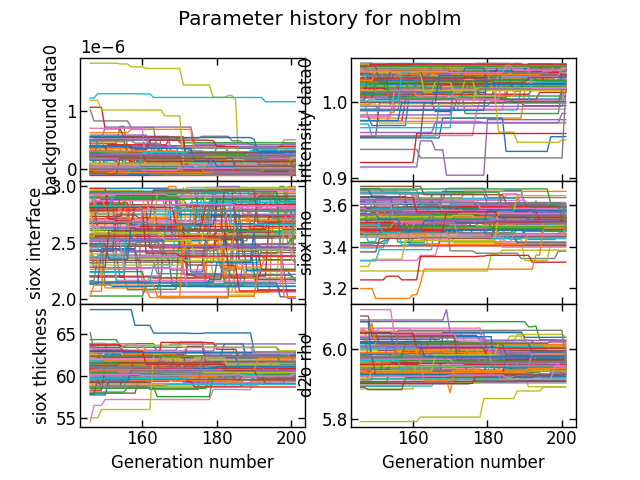

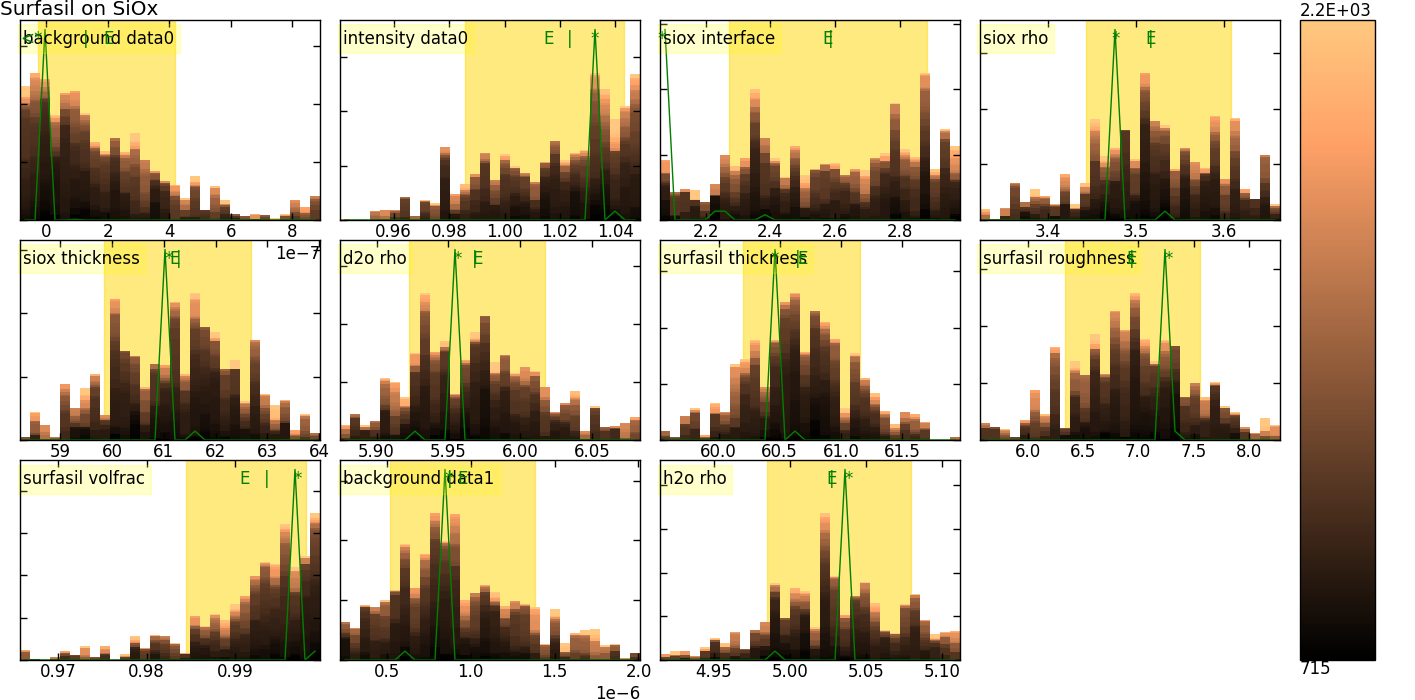

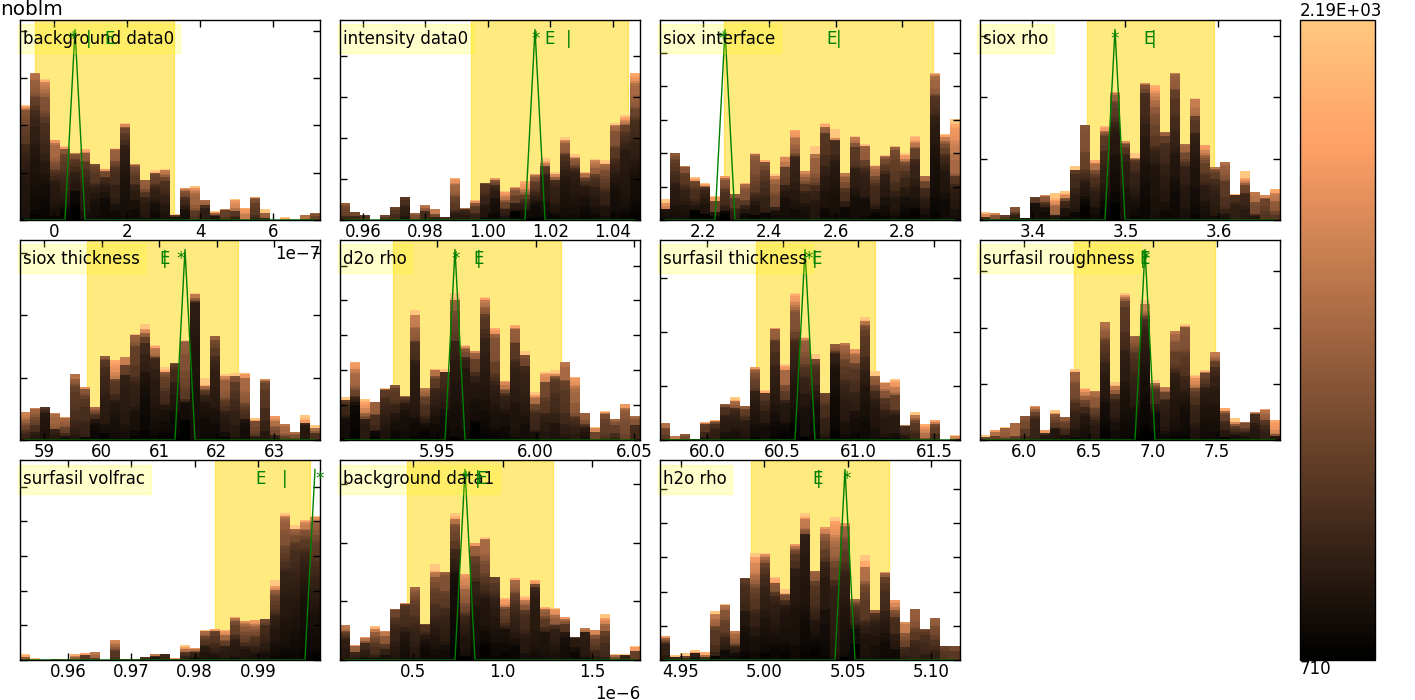

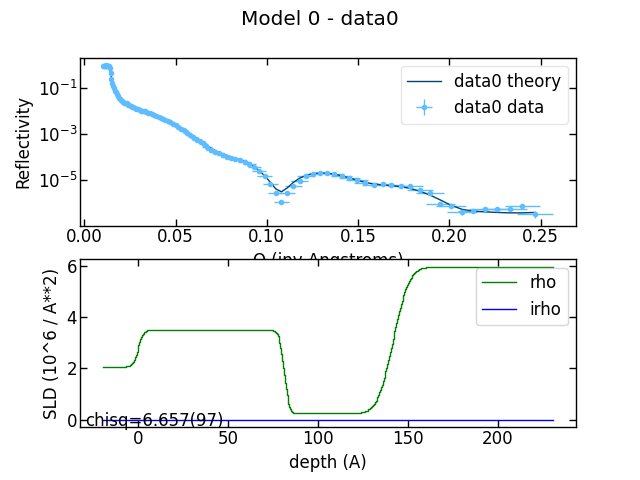

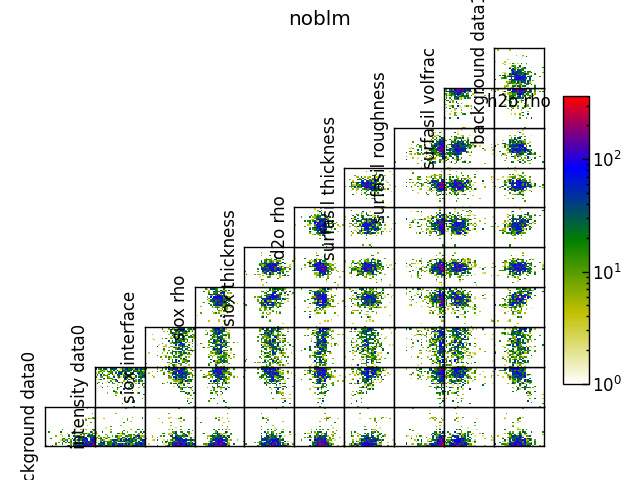

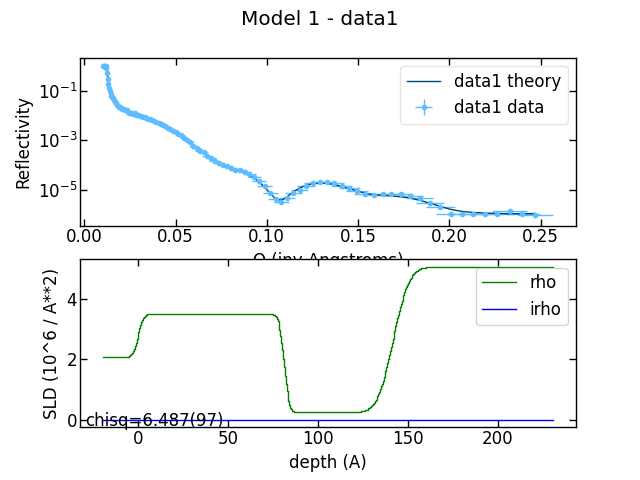

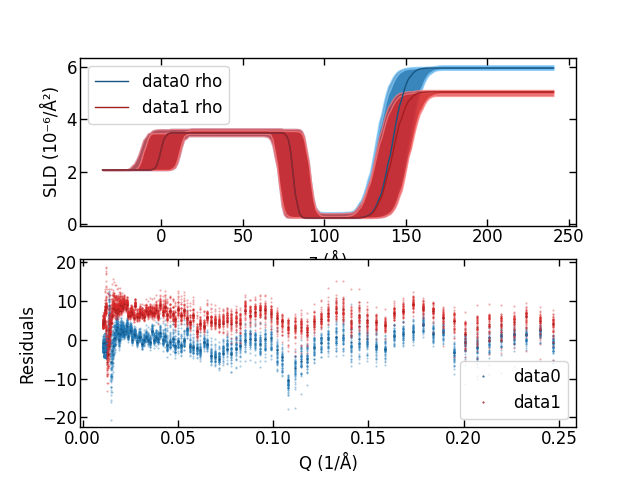

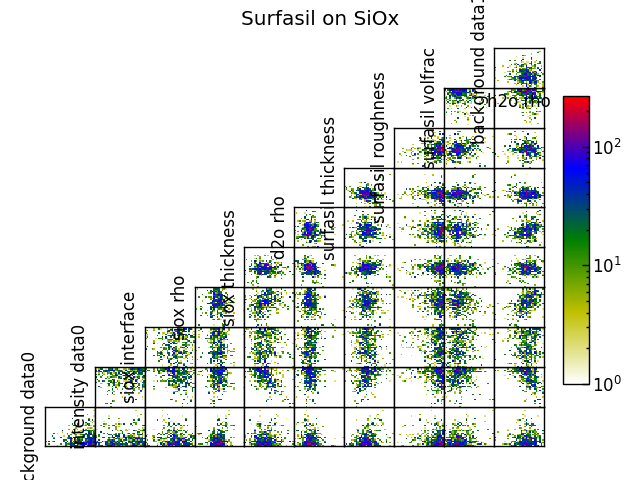

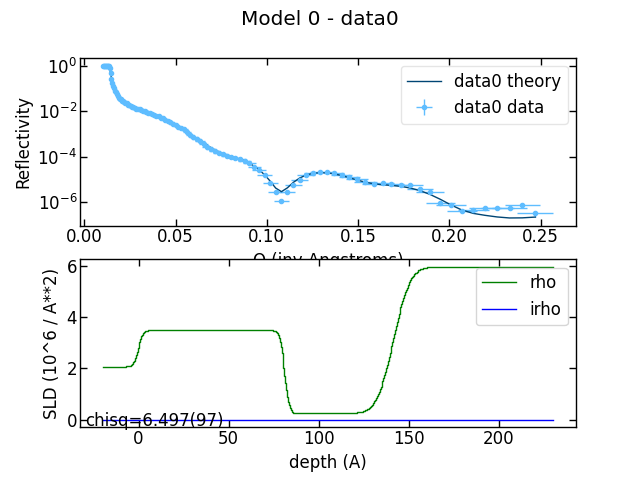

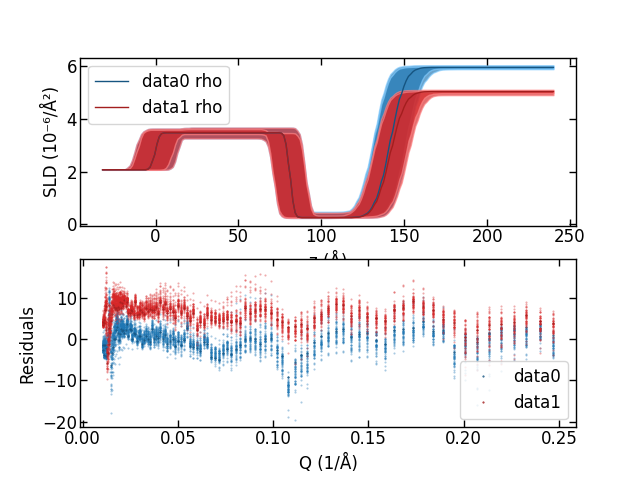

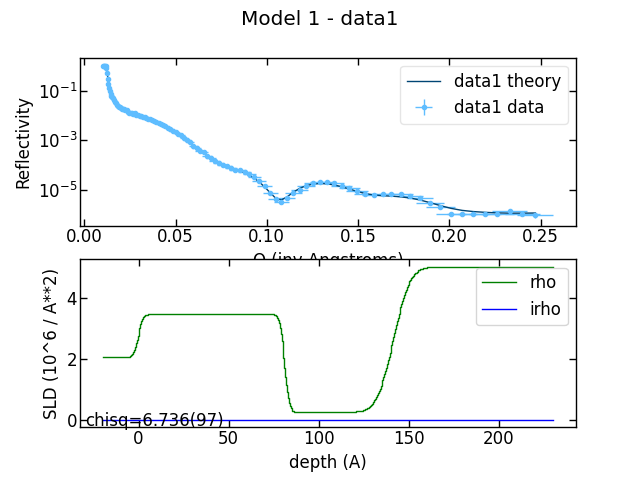

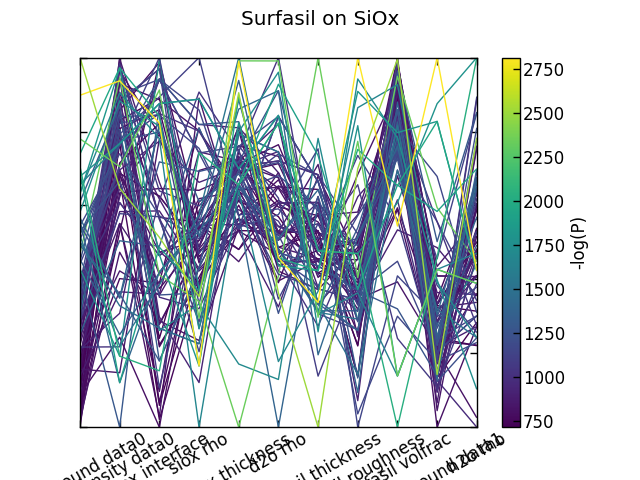

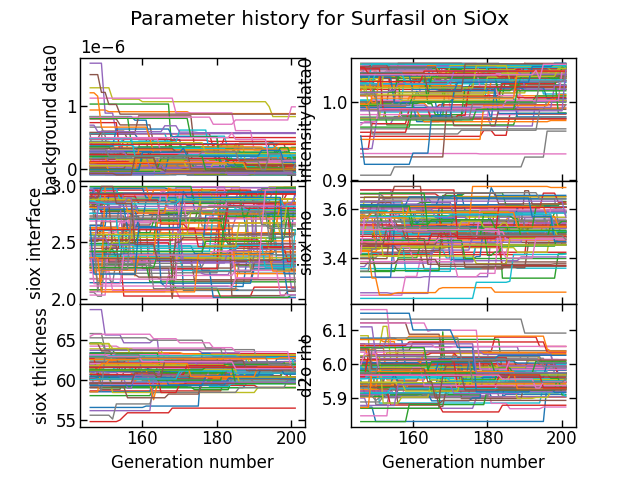

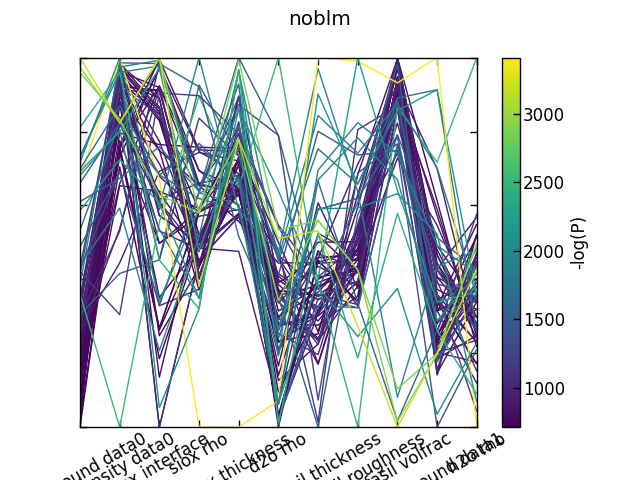

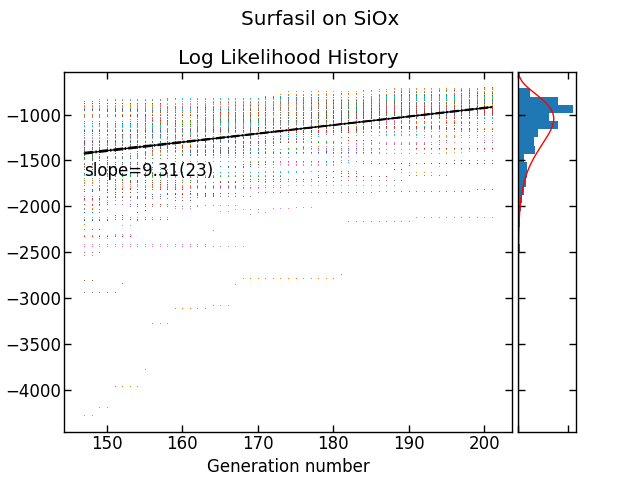

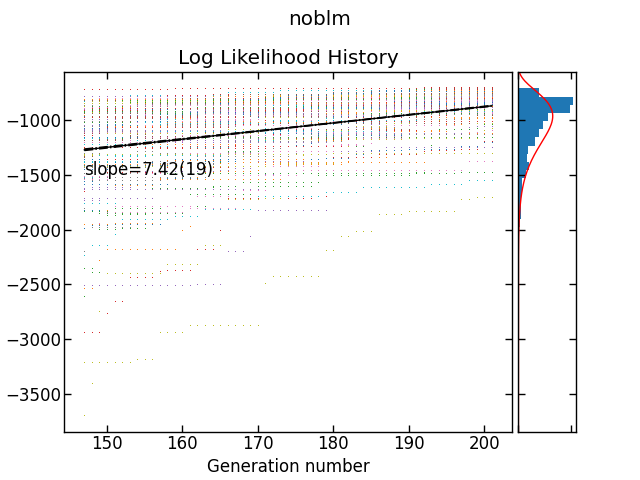

In [8]:
from IPython.display import Image, display
import glob
for file in glob.glob(store+"/*.png"):
    display(Image(filename=file))


# Publication-ready graphs

...

# Useful Routines

In [18]:
def plot_components(z, groups):
    fig, ax = plt.subplots(3, 1, figsize=(20,24))
    fig.patch.set_facecolor('white')
    ax[0].set_ylabel('Area')
    ax[1].set_ylabel('nSLD')
    ax[2].set_ylabel('nSL')
    ax[0].set_xlabel('z')
    ax[1].set_xlabel('z')
    ax[2].set_xlabel('z')

    # plot individual components

    for blm in groups:
        dd, aArea, anSL = blm.fnWriteProfile(z)
        aArea = np.array(aArea)
        anSL = np.array(anSL)
        sel = aArea>0
        anSLD = anSL[sel] / (aArea[sel] * stepsize)
        ax[0].plot(z[sel], aArea[sel])
        ax[1].plot(z[sel], anSLD)
        ax[2].plot(z[sel], anSL[sel])

        for key, val in blm.__dict__.items():       # cycle over all attributes of blm
            if isinstance(val, mol.nSLDObj):        # if instance of nSLDObj, plot its profile
                ddp, aArea, anSL = val.fnWriteProfile(z)
                aArea = np.array(aArea)
                anSL = np.array(anSL)
                sel = aArea>0
                anSLD = anSL[sel] / (aArea[sel] * stepsize)
                ax[0].plot(z[sel], aArea[sel], '-', label=val.name)
                ax[1].plot(z[sel], anSLD, '-', label=val.name)
                ax[2].plot(z[sel], anSL[sel], '-', label=val.name)

    ax[0].legend(loc=0)
    ax[1].legend(loc=0)
    ax[2].legend(loc=0)

Load the best-fit canvas and show it.

In [19]:
model = load_model(runfile+'.py')
load_best(model, store+'/'+runfile+'.par')
model.chisq_str()

'6.925(62)'

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


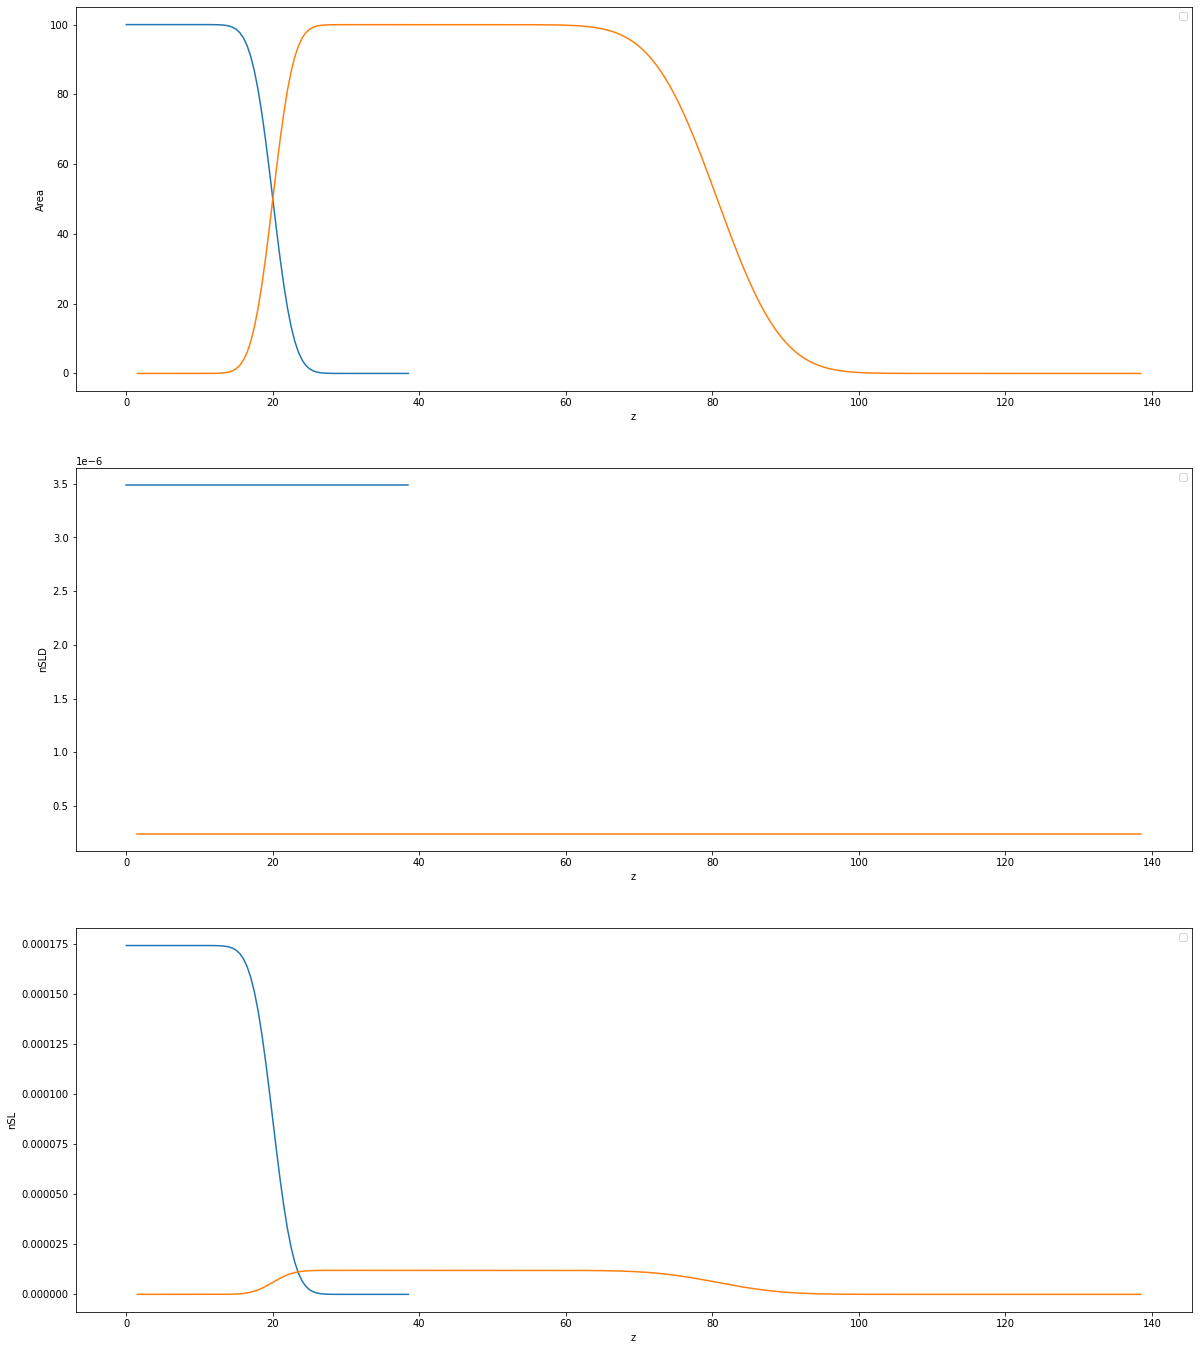

In [20]:
z = np.arange(model.dimension) * model.stepsize
stepsize = model.stepsize

plot_components(z, model.groups)

In [22]:
from bumps.dream.state import load_state
state = load_state(store+'/'+runfile)
state.mark_outliers() # ignore outlier chains
#state.show()  # Plot statistics

mts 50.37617812965514 0.42444849070660606 50.35354740794778
lts 60.752356259310275 0.8488969814132121 60.70709481589556


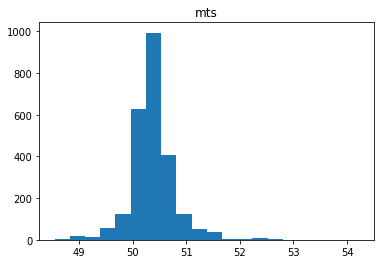

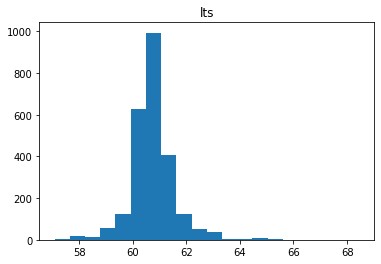

mts 60.752356259310275 0.8488969814132121 60.70709481589556
lts 6.923813434916068 0.8369339037739079 6.910011178630528


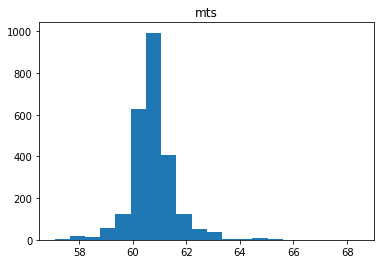

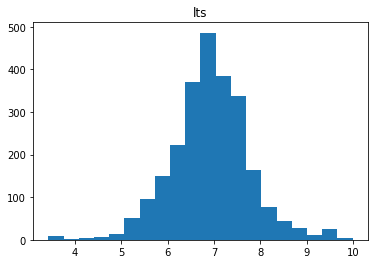

In [35]:
dw = state.draw(thin=5)

# calculate the actual mult_tether and l_tether distributions
mts = list()
lts = list()

for i, d in enumerate(dw.points):
    #if np.mod(i, 100)==0:
    #    print(i, flush=True)
    model.setp(d)
    model.chisq_str()
    mts.append(model.groups[1].l)
    lts.append(model.groups[1].sigma2)

plt.figure()
plt.hist(mts, bins=20)
plt.title('mts')

plt.figure()
plt.hist(lts, bins=20)
plt.title('lts')

print('mts', np.mean(mts), np.std(mts), np.median(mts))
print('lts', np.mean(lts), np.std(lts), np.median(lts))


In [36]:
from bumps.dream.stats import credible_interval

print(credible_interval(np.array(mts), [0, 0.68, 0.95]))
print(credible_interval(np.array(lts), [0, 0.68, 0.95]))

[[50.35354741 50.35354741]
 [50.0657152  50.64696812]
 [49.54969301 51.3732715 ]]
[[60.70709482 60.70709482]
 [60.13143041 61.29393625]
 [59.09938602 62.74654301]]
[[60.70709482 60.70709482]
 [60.13143041 61.29393625]
 [59.09938602 62.74654301]]
[[6.91001118 6.91001118]
 [6.16686228 7.59906115]
 [5.30091604 8.69169828]]
